# Multivariate LSTM 

In [30]:
import numpy
from numpy import concatenate
import math
from math import sqrt

import pandas as pd
from pandas.plotting import autocorrelation_plot

#import statsmodels.api as sm
#from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
eur = pd.read_csv("/Users/john/Desktop/eurv1.csv", parse_dates=['time'], index_col=['time'], 
                   usecols= ['OpenMid', 'HighMid', 'LowMid', 'CloseMid', 'lowBid','highAsk','volume', 'time'])

eur1d = eur.resample('1D').agg({'OpenMid': 'first', 
                       'HighMid': 'max', 
                        'LowMid': 'min', 
                      'CloseMid': 'last',
                       'lowBid' : 'min',
                      'highAsk' : 'max',
                       'volume' : 'sum'})
eur1d.dropna(inplace=True)
#eur1d.fillna(method='ffill', inplace=True)

eur1d['Volatility'] = eur1d['highAsk'] - eur1d['lowBid']
eur1d.head(3)

,OpenMid,HighMid,LowMid,CloseMid,lowBid,highAsk,volume,Volatility
time,,,,,,,,
2014-01-01,1.375250,1.377385,1.374245,1.376425,1.37353,1.37757,5106.0,0.00404
2014-01-02,1.376435,1.377565,1.362960,1.366535,1.36290,1.37769,102368.0,0.01479
2014-01-03,1.366535,1.367205,1.358250,1.358885,1.35818,1.36727,68106.0,0.00909


In [32]:
# Add USDJPY volatility and volume
jpy = pd.read_csv("/Users/john/Desktop/jpyv1.csv", parse_dates=['time'], index_col=['time'], 
                  usecols= ['OpenMid', 'HighMid', 'LowMid', 'CloseMid', 'lowBid','highAsk','volume', 'time'])

# Resample USDJPY to 1 day
jpy1d = jpy.resample('1D').agg({'OpenMid': 'first', 
                       'HighMid': 'max', 
                        'LowMid': 'min', 
                      'CloseMid': 'last',
                       'lowBid' : 'min',
                      'highAsk' : 'max',
                       'volume' : 'sum'})

# Calculate the USDJPY volatility
jpy1d['Volatility'] = jpy1d['highAsk'] - jpy1d['lowBid']

# Forward fill NaN values for USDJPY
jpy1d.fillna(method='ffill', inplace=True)

# Add USDJPY volatility and volume to eur1d dataframe
eur1d['JPYvolavility'] = jpy1d['Volatility']
eur1d['JPYvolume'] = jpy1d['volume']

In [33]:
eur1d1 = eur1d[['Volatility', 'volume', 'JPYvolavility', 'JPYvolume']]
eur1d1.head(2)

,Volatility,volume,JPYvolavility,JPYvolume
time,,,,
2014-01-01,0.00404,5106.0,0.260,2737.0
2014-01-02,0.01479,102368.0,0.909,77506.0


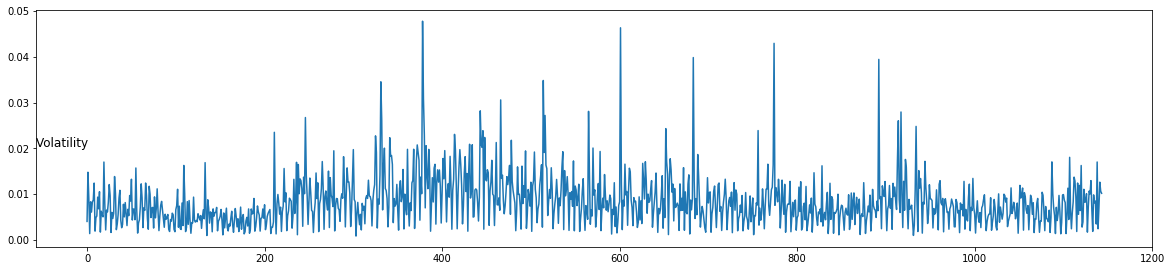

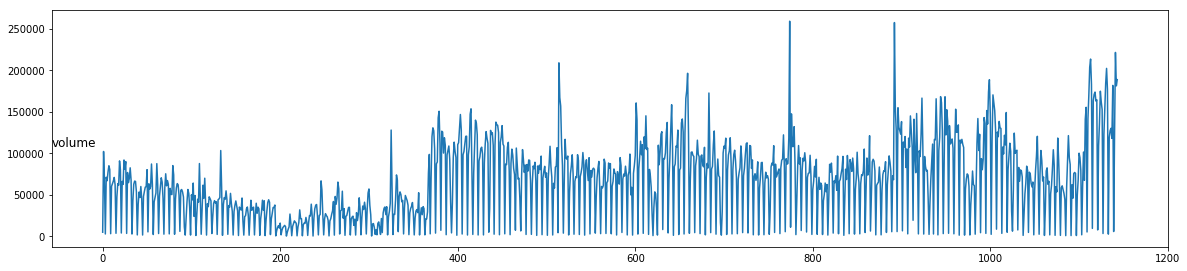

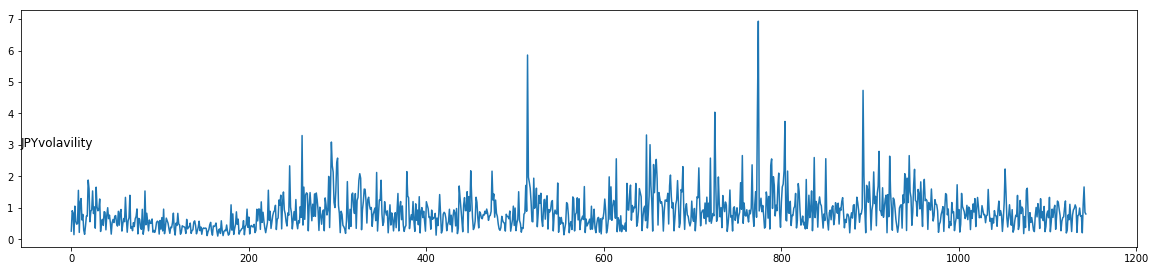

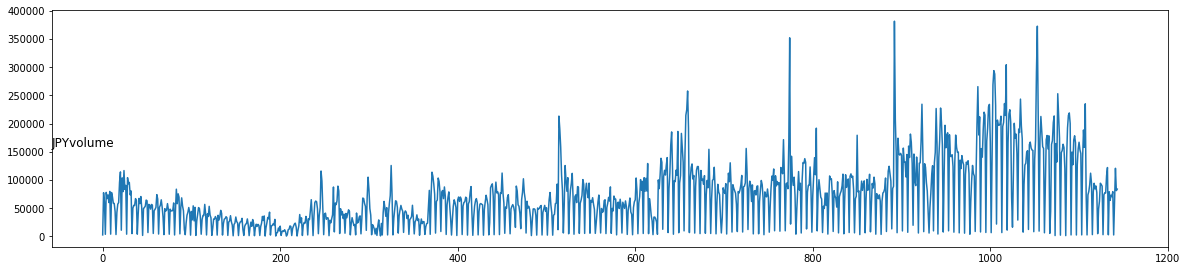

In [34]:
values = eur1d1.values

# specify columns to plot
groups = [0, 1, 2, 3]
i = 1

# plot each column
pyplot.figure()
for group in groups:
    plt.figure(figsize=(20,20))
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(eur1d1.columns[group], y=0.4, loc='left')
    i += 1
pyplot.show()

In [35]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# get dataset values
values = eur1d1.values

# ensure all data is float
values = values.astype('float64')

# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1  -0.863743  -0.964205  -0.954020  -0.989113 -0.406004
2  -0.406004  -0.212750  -0.763948  -0.596624 -0.648712
3  -0.648712  -0.477461  -0.784156  -0.682388 -0.977007
4  -0.977007  -0.980646  -0.987114  -0.983827 -0.681499
5  -0.681499  -0.452490  -0.721482  -0.593563 -0.776879


In [36]:
# split into train and test sets
values = reframed.values
train = values[:-540, :]
test = values[-540:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(603, 1, 4) (603,) (540, 1, 4) (540,)


In [37]:
# design network
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=10, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 603 samples, validate on 540 samples
Epoch 1/20
0s - loss: 0.3038 - val_loss: 0.3362
Epoch 2/20
0s - loss: 0.2007 - val_loss: 0.2667
Epoch 3/20
0s - loss: 0.1848 - val_loss: 0.2560
Epoch 4/20
0s - loss: 0.1831 - val_loss: 0.2484
Epoch 5/20
0s - loss: 0.1817 - val_loss: 0.2426
Epoch 6/20
0s - loss: 0.1811 - val_loss: 0.2374
Epoch 7/20
0s - loss: 0.1804 - val_loss: 0.2318
Epoch 8/20
0s - loss: 0.1795 - val_loss: 0.2265
Epoch 9/20
0s - loss: 0.1786 - val_loss: 0.2229
Epoch 10/20
0s - loss: 0.1781 - val_loss: 0.2189
Epoch 11/20
0s - loss: 0.1778 - val_loss: 0.2144
Epoch 12/20
0s - loss: 0.1772 - val_loss: 0.2128
Epoch 13/20
0s - loss: 0.1771 - val_loss: 0.2102
Epoch 14/20
0s - loss: 0.1767 - val_loss: 0.2080
Epoch 15/20
0s - loss: 0.1764 - val_loss: 0.2056
Epoch 16/20
0s - loss: 0.1761 - val_loss: 0.2036
Epoch 17/20
0s - loss: 0.1760 - val_loss: 0.2021
Epoch 18/20
0s - loss: 0.1758 - val_loss: 0.2006
Epoch 19/20
0s - loss: 0.1755 - val_loss: 0.1987
Epoch 20/20
0s - loss: 0.1754 - 

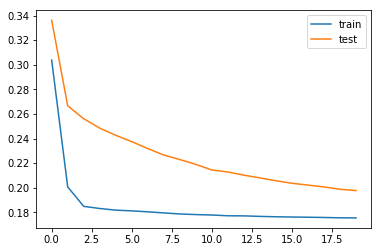

In [38]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.00617


# Try with Epoch 200

In [40]:
# split into train and test sets
values = reframed.values
train = values[:-540, :]
test = values[-540:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(603, 1, 4) (603,) (540, 1, 4) (540,)


In [41]:
# design network
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=10, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 603 samples, validate on 540 samples
Epoch 1/200
0s - loss: 0.6119 - val_loss: 0.5739
Epoch 2/200
0s - loss: 0.4208 - val_loss: 0.3822
Epoch 3/200
0s - loss: 0.2452 - val_loss: 0.2255
Epoch 4/200
0s - loss: 0.1801 - val_loss: 0.2116
Epoch 5/200
0s - loss: 0.1773 - val_loss: 0.2100
Epoch 6/200
0s - loss: 0.1774 - val_loss: 0.2083
Epoch 7/200
0s - loss: 0.1772 - val_loss: 0.2081
Epoch 8/200
0s - loss: 0.1772 - val_loss: 0.2074
Epoch 9/200
0s - loss: 0.1773 - val_loss: 0.2065
Epoch 10/200
0s - loss: 0.1774 - val_loss: 0.2051
Epoch 11/200
0s - loss: 0.1772 - val_loss: 0.2048
Epoch 12/200
0s - loss: 0.1773 - val_loss: 0.2039
Epoch 13/200
0s - loss: 0.1772 - val_loss: 0.2031
Epoch 14/200
0s - loss: 0.1770 - val_loss: 0.2029
Epoch 15/200
0s - loss: 0.1776 - val_loss: 0.2016
Epoch 16/200
0s - loss: 0.1772 - val_loss: 0.2014
Epoch 17/200
0s - loss: 0.1774 - val_loss: 0.2003
Epoch 18/200
0s - loss: 0.1771 - val_loss: 0.2000
Epoch 19/200
0s - loss: 0.1770 - val_loss: 0.1997
Epoch 20/200


0s - loss: 0.1734 - val_loss: 0.1732
Epoch 164/200
0s - loss: 0.1739 - val_loss: 0.1733
Epoch 165/200
0s - loss: 0.1739 - val_loss: 0.1731
Epoch 166/200
0s - loss: 0.1738 - val_loss: 0.1733
Epoch 167/200
0s - loss: 0.1738 - val_loss: 0.1731
Epoch 168/200
0s - loss: 0.1737 - val_loss: 0.1734
Epoch 169/200
0s - loss: 0.1738 - val_loss: 0.1731
Epoch 170/200
0s - loss: 0.1738 - val_loss: 0.1733
Epoch 171/200
0s - loss: 0.1738 - val_loss: 0.1731
Epoch 172/200
0s - loss: 0.1738 - val_loss: 0.1729
Epoch 173/200
0s - loss: 0.1736 - val_loss: 0.1731
Epoch 174/200
0s - loss: 0.1737 - val_loss: 0.1729
Epoch 175/200
0s - loss: 0.1736 - val_loss: 0.1732
Epoch 176/200
0s - loss: 0.1737 - val_loss: 0.1729
Epoch 177/200
0s - loss: 0.1735 - val_loss: 0.1732
Epoch 178/200
0s - loss: 0.1736 - val_loss: 0.1730
Epoch 179/200
0s - loss: 0.1736 - val_loss: 0.1727
Epoch 180/200
0s - loss: 0.1735 - val_loss: 0.1730
Epoch 181/200
0s - loss: 0.1736 - val_loss: 0.1727
Epoch 182/200
0s - loss: 0.1735 - val_loss: 0

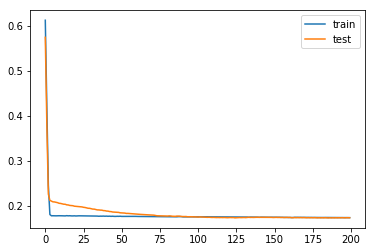

In [42]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [43]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.00548


In [44]:
eur1d1.head(3)

,Volatility,volume,JPYvolavility,JPYvolume
time,,,,
2014-01-01,0.00404,5106.0,0.260,2737.0
2014-01-02,0.01479,102368.0,0.909,77506.0
2014-01-03,0.00909,68106.0,0.840,61168.0


In [45]:
eur1d2 = eur1d1.copy()
eur1d2['dayofweek'] = eur1d.index.dayofweek

In [46]:
eur1d2['Mon'] = [1 if x == 0 else 0 for x in eur1d2['dayofweek']]
eur1d2['Tues'] = [1 if x == 1 else 0 for x in eur1d2['dayofweek']]
eur1d2['Wed'] = [1 if x == 2 else 0 for x in eur1d2['dayofweek']]
eur1d2['Thur'] = [1 if x == 3 else 0 for x in eur1d2['dayofweek']]
eur1d2['Fri'] = [1 if x == 4 else 0 for x in eur1d2['dayofweek']]
eur1d2['Sat'] = [1 if x == 5 else 0 for x in eur1d2['dayofweek']]
eur1d2['Sun'] = [1 if x == 6 else 0 for x in eur1d2['dayofweek']]

In [47]:
eur1d2.head(3)

,Volatility,volume,JPYvolavility,JPYvolume,dayofweek,Mon,Tues,Wed,Thur,Fri,Sat,Sun
time,,,,,,,,,,,,
2014-01-01,0.00404,5106.0,0.260,2737.0,2,0,0,1,0,0,0,0
2014-01-02,0.01479,102368.0,0.909,77506.0,3,0,0,0,1,0,0,0
2014-01-03,0.00909,68106.0,0.840,61168.0,4,0,0,0,0,1,0,0


In [124]:
# get dataset values
values = eur1d2.values

# ensure all data is float
values = values.astype('float64')

# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,13,14,15,16,17,18,19,20,21,22,23]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var6(t-1)  var7(t-1)  \
1  -0.863743  -0.964205  -0.954020  -0.989113       -1.0       -1.0   
2  -0.406004  -0.212750  -0.763948  -0.596624       -1.0       -1.0   
3  -0.648712  -0.477461  -0.784156  -0.682388       -1.0       -1.0   
4  -0.977007  -0.980646  -0.987114  -0.983827       -1.0       -1.0   
5  -0.681499  -0.452490  -0.721482  -0.593563        1.0       -1.0   

   var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)   var1(t)  
1        1.0       -1.0        -1.0        -1.0        -1.0 -0.406004  
2       -1.0        1.0        -1.0        -1.0        -1.0 -0.648712  
3       -1.0       -1.0         1.0        -1.0        -1.0 -0.977007  
4       -1.0       -1.0        -1.0        -1.0         1.0 -0.681499  
5       -1.0       -1.0        -1.0        -1.0        -1.0 -0.776879  


In [125]:
# split into train and test sets
values = reframed.values
train = values[:-540, :]
test = values[-540:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(603, 1, 11) (603,) (540, 1, 11) (540,)


In [126]:
# design network
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=10, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 603 samples, validate on 540 samples
Epoch 1/20
0s - loss: 0.4477 - val_loss: 0.3448
Epoch 2/20
0s - loss: 0.1996 - val_loss: 0.1625
Epoch 3/20
0s - loss: 0.1510 - val_loss: 0.1698
Epoch 4/20
0s - loss: 0.1509 - val_loss: 0.1649
Epoch 5/20
0s - loss: 0.1501 - val_loss: 0.1616
Epoch 6/20
0s - loss: 0.1494 - val_loss: 0.1589
Epoch 7/20
0s - loss: 0.1483 - val_loss: 0.1592
Epoch 8/20
0s - loss: 0.1484 - val_loss: 0.1587
Epoch 9/20
0s - loss: 0.1479 - val_loss: 0.1580
Epoch 10/20
0s - loss: 0.1478 - val_loss: 0.1580
Epoch 11/20
0s - loss: 0.1474 - val_loss: 0.1565
Epoch 12/20
0s - loss: 0.1468 - val_loss: 0.1547
Epoch 13/20
0s - loss: 0.1461 - val_loss: 0.1544
Epoch 14/20
0s - loss: 0.1456 - val_loss: 0.1536
Epoch 15/20
0s - loss: 0.1454 - val_loss: 0.1529
Epoch 16/20
0s - loss: 0.1452 - val_loss: 0.1513
Epoch 17/20
0s - loss: 0.1446 - val_loss: 0.1512
Epoch 18/20
0s - loss: 0.1442 - val_loss: 0.1507
Epoch 19/20
0s - loss: 0.1440 - val_loss: 0.1506
Epoch 20/20
0s - loss: 0.1440 - 

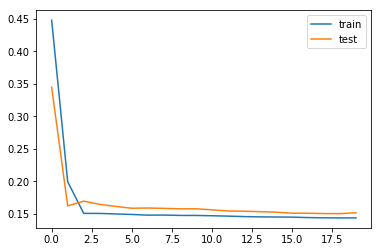

ValueError: operands could not be broadcast together with shapes (540,11) (12,) (540,11) 

In [127]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse)

In [128]:
eur1d1.head(3)

,Volatility,volume,JPYvolavility,JPYvolume
time,,,,
2014-01-01,0.00404,5106.0,0.260,2737.0
2014-01-02,0.01479,102368.0,0.909,77506.0
2014-01-03,0.00909,68106.0,0.840,61168.0


In [141]:
econ = pd.read_csv("/Users/john/Desktop/Econ Indicators.csv", parse_dates=['DateTime'])

In [142]:
econ.head(2)

,DateTime,EUIR,EUCONF,USIR,FEDCONF,USGDP,EUGDP,USCPI,EUCPI,NFP,EUUR,USR,USCC,USADP,USISM,GPMI,GZEW,GIFO,GUC
0,2014-01-01 11:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2014-01-02 04:53:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [143]:
# Change from NY time to UTC
econ.DateTime = econ.DateTime + pd.DateOffset(hours=4)

In [151]:
econ.head(5)

,EUIR,EUCONF,USIR,FEDCONF,USGDP,EUGDP,USCPI,EUCPI,NFP,EUUR,USR,USCC,USADP,USISM,GPMI,GZEW,GIFO,GUC
DateTime,,,,,,,,,,,,,,,,,,
2014-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2014-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2014-01-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2014-01-07,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2014-01-08,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [145]:
econ.DateTime = econ.DateTime.apply(lambda x: x.date())

In [146]:
econ.set_index('DateTime', inplace=True)
econ.head(2)

,EUIR,EUCONF,USIR,FEDCONF,USGDP,EUGDP,USCPI,EUCPI,NFP,EUUR,USR,USCC,USADP,USISM,GPMI,GZEW,GIFO,GUC
DateTime,,,,,,,,,,,,,,,,,,
2014-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2014-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [152]:
Final = eur1d1.merge(econ, how='left', right_index=True, left_index=True)
Final.fillna(0, inplace=True)

In [130]:
Final.columns

Index(['Volatility', 'volume', 'JPYvolavility', 'JPYvolume', 'EUIR', 'EUCONF',
       'USIR', 'FEDCONF', 'USGDP', 'EUGDP', 'USCPI', 'EUCPI', 'NFP', 'EUUR',
       'USR', 'USCC', 'USADP', 'USISM', 'GPMI', 'GZEW', 'GIFO', 'GUC'],
      dtype='object')

In [163]:
# get dataset values
values = Final.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.068129   0.017897   0.022990   0.005444        0.0        0.0   
2   0.296998   0.393625   0.118026   0.201688        0.0        0.0   
3   0.175644   0.261269   0.107922   0.158806        0.0        0.0   
4   0.011497   0.009677   0.006443   0.008087        0.0        0.0   
5   0.159251   0.273755   0.139259   0.203218        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...     var14(t-1)  \
1        0.0        0.0        0.0         0.0    ...            0.0   
2        0.0        0.0        0.0         0.0    ...            0.0   
3        0.0        0.0        0.0         0.0    ...            0.0   
4        0.0        0.0        0.0         0.0    ...            0.0   
5        0.0        0.0        0.0         0.0    ...            0.0   

   var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  var19(t-1)  var20(t-1)  \
1         0.0         0.0         0.0         1.0         0.0  

In [164]:
# split into train and test sets
values = reframed.values
train = values[:-540, :]
test = values[-540:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(842, 1, 22) (842,) (540, 1, 22) (540,)


In [165]:
# design network
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=10, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 842 samples, validate on 540 samples
Epoch 1/20
1s - loss: 0.1267 - val_loss: 0.0776
Epoch 2/20
0s - loss: 0.0993 - val_loss: 0.0808
Epoch 3/20
0s - loss: 0.0956 - val_loss: 0.0789
Epoch 4/20
0s - loss: 0.0924 - val_loss: 0.0792
Epoch 5/20
0s - loss: 0.0902 - val_loss: 0.0773
Epoch 6/20
0s - loss: 0.0881 - val_loss: 0.0761
Epoch 7/20
0s - loss: 0.0862 - val_loss: 0.0754
Epoch 8/20
0s - loss: 0.0847 - val_loss: 0.0739
Epoch 9/20
0s - loss: 0.0833 - val_loss: 0.0735
Epoch 10/20
0s - loss: 0.0822 - val_loss: 0.0723
Epoch 11/20
0s - loss: 0.0810 - val_loss: 0.0716
Epoch 12/20
0s - loss: 0.0802 - val_loss: 0.0710
Epoch 13/20
0s - loss: 0.0798 - val_loss: 0.0708
Epoch 14/20
0s - loss: 0.0796 - val_loss: 0.0702
Epoch 15/20
0s - loss: 0.0791 - val_loss: 0.0693
Epoch 16/20
0s - loss: 0.0790 - val_loss: 0.0692
Epoch 17/20
0s - loss: 0.0788 - val_loss: 0.0686
Epoch 18/20
0s - loss: 0.0784 - val_loss: 0.0687
Epoch 19/20
0s - loss: 0.0783 - val_loss: 0.0683
Epoch 20/20
0s - loss: 0.0780 - 

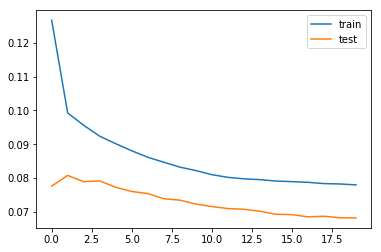

Test RMSE: 0.00452


In [166]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse)

# 200 Epoch

In [169]:
# split into train and test sets
values = reframed.values
train = values[:-540, :]
test = values[-540:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(842, 1, 22) (842,) (540, 1, 22) (540,)


In [170]:
# design network
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=10, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 842 samples, validate on 540 samples
Epoch 1/200
1s - loss: 0.1314 - val_loss: 0.0687
Epoch 2/200
0s - loss: 0.0925 - val_loss: 0.0794
Epoch 3/200
0s - loss: 0.0906 - val_loss: 0.0789
Epoch 4/200
0s - loss: 0.0878 - val_loss: 0.0773
Epoch 5/200
0s - loss: 0.0850 - val_loss: 0.0764
Epoch 6/200
0s - loss: 0.0830 - val_loss: 0.0761
Epoch 7/200
0s - loss: 0.0816 - val_loss: 0.0760
Epoch 8/200
0s - loss: 0.0809 - val_loss: 0.0745
Epoch 9/200
0s - loss: 0.0803 - val_loss: 0.0747
Epoch 10/200
0s - loss: 0.0800 - val_loss: 0.0743
Epoch 11/200
0s - loss: 0.0796 - val_loss: 0.0739
Epoch 12/200
0s - loss: 0.0793 - val_loss: 0.0734
Epoch 13/200
0s - loss: 0.0789 - val_loss: 0.0723
Epoch 14/200
0s - loss: 0.0787 - val_loss: 0.0722
Epoch 15/200
0s - loss: 0.0785 - val_loss: 0.0719
Epoch 16/200
0s - loss: 0.0784 - val_loss: 0.0715
Epoch 17/200
0s - loss: 0.0781 - val_loss: 0.0708
Epoch 18/200
0s - loss: 0.0779 - val_loss: 0.0699
Epoch 19/200
0s - loss: 0.0776 - val_loss: 0.0696
Epoch 20/200


0s - loss: 0.0703 - val_loss: 0.0630
Epoch 164/200
0s - loss: 0.0703 - val_loss: 0.0628
Epoch 165/200
0s - loss: 0.0703 - val_loss: 0.0629
Epoch 166/200
0s - loss: 0.0702 - val_loss: 0.0627
Epoch 167/200
0s - loss: 0.0702 - val_loss: 0.0627
Epoch 168/200
0s - loss: 0.0703 - val_loss: 0.0629
Epoch 169/200
0s - loss: 0.0702 - val_loss: 0.0630
Epoch 170/200
0s - loss: 0.0703 - val_loss: 0.0630
Epoch 171/200
0s - loss: 0.0703 - val_loss: 0.0631
Epoch 172/200
0s - loss: 0.0703 - val_loss: 0.0631
Epoch 173/200
0s - loss: 0.0703 - val_loss: 0.0630
Epoch 174/200
0s - loss: 0.0702 - val_loss: 0.0629
Epoch 175/200
0s - loss: 0.0701 - val_loss: 0.0627
Epoch 176/200
0s - loss: 0.0702 - val_loss: 0.0629
Epoch 177/200
0s - loss: 0.0702 - val_loss: 0.0633
Epoch 178/200
0s - loss: 0.0700 - val_loss: 0.0630
Epoch 179/200
0s - loss: 0.0701 - val_loss: 0.0629
Epoch 180/200
0s - loss: 0.0701 - val_loss: 0.0631
Epoch 181/200
0s - loss: 0.0699 - val_loss: 0.0630
Epoch 182/200
0s - loss: 0.0700 - val_loss: 0

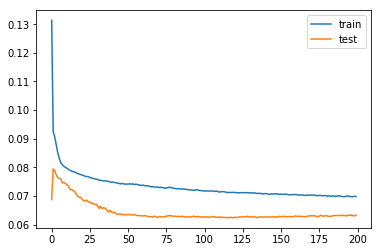

Test RMSE: 0.00453


In [171]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse)

# 50 Neurons

In [172]:
# split into train and test sets
values = reframed.values
train = values[:-540, :]
test = values[-540:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(842, 1, 22) (842,) (540, 1, 22) (540,)


In [173]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=70, batch_size=10, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 842 samples, validate on 540 samples
Epoch 1/70
1s - loss: 0.0925 - val_loss: 0.0702
Epoch 2/70
0s - loss: 0.0843 - val_loss: 0.0665
Epoch 3/70
0s - loss: 0.0833 - val_loss: 0.0666
Epoch 4/70
0s - loss: 0.0834 - val_loss: 0.0678
Epoch 5/70
0s - loss: 0.0826 - val_loss: 0.0668
Epoch 6/70
0s - loss: 0.0823 - val_loss: 0.0659
Epoch 7/70
0s - loss: 0.0818 - val_loss: 0.0658
Epoch 8/70
0s - loss: 0.0812 - val_loss: 0.0660
Epoch 9/70
0s - loss: 0.0811 - val_loss: 0.0646
Epoch 10/70
0s - loss: 0.0802 - val_loss: 0.0640
Epoch 11/70
0s - loss: 0.0797 - val_loss: 0.0638
Epoch 12/70
0s - loss: 0.0799 - val_loss: 0.0637
Epoch 13/70
0s - loss: 0.0795 - val_loss: 0.0643
Epoch 14/70
0s - loss: 0.0792 - val_loss: 0.0645
Epoch 15/70
0s - loss: 0.0792 - val_loss: 0.0643
Epoch 16/70
0s - loss: 0.0791 - val_loss: 0.0644
Epoch 17/70
0s - loss: 0.0784 - val_loss: 0.0652
Epoch 18/70
0s - loss: 0.0786 - val_loss: 0.0646
Epoch 19/70
0s - loss: 0.0781 - val_loss: 0.0648
Epoch 20/70
0s - loss: 0.0785 - 

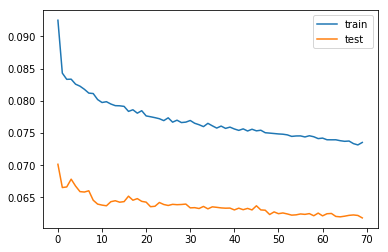

Test RMSE: 0.00443


In [174]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse)